# Intuit Quickbooks' Mailing Prediction

In [1]:
from math import sqrt

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyrsm as rsm
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats as sm
from sklearn import metrics
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.neural_network import MLPClassifier
from utils import functions
from sklearn import preprocessing
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import logit
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,roc_auc_score

# increase plot resolution
# mpl.rcParams["figure.dpi"] = 150

In [2]:
## loading the data
intuit75k = pd.read_pickle("data/intuit75k.pkl")
intuit75k["res1_yes"] = (intuit75k["res1"] == "Yes").astype(int)
intuit75k.head()

,id,zip,zip_bins,sex,bizflag,numords,dollars,last,sincepurch,version1,owntaxprod,upgraded,res1,training,res1_yes
0,1,94553,18,Male,0,2,109.5,5,12,0,0,0,No,1,0
1,2,53190,10,Unknown,0,1,69.5,4,3,0,0,0,No,0,0
2,3,37091,8,Male,0,4,93.0,14,29,0,0,1,No,0,0
3,4,02125,1,Male,0,1,22.0,17,1,0,0,0,No,1,0
4,5,60201,11,Male,0,1,24.5,2,3,0,0,0,No,0,0


In [3]:
intuit75k['zip_bins'] = intuit75k.zip_bins.astype('category')
intuit75k = intuit75k.assign(
    zip801 = (intuit75k.zip =='00801').astype(int),
    zip804 = (intuit75k.zip =='00804').astype(int),
)
pred = intuit75k.copy()

## 1. Logistic Regression

In this part, we create a logistic regression model and will compare the performance of the model with others.

Note: Logistic model will not be used to prediction.

In [4]:
%run sub-notebooks/logit.ipynb

Actual profit in wave1:38322.21000000001, Expected profit in wave2: 441907.05


## 2. Neural Networks

In this part, we create a series of neural networking models and will pickup the top models based on their actual profit in wave1 and expected profit in wave2. Accuracy, recall and precision will also be taken into consideration.

All models will be built on the data after standardization.

In [5]:
to_std = ['numords','dollars','last','sincepurch']
intuit75k_std = intuit75k.copy()
intuit75k_std[to_std] = rsm.scale_df(intuit75k_std[to_std], sf=1, train=intuit75k_std.training == 1)
intuit75k_std['sex'] = rsm.ifelse(intuit75k_std['sex']=='Male',2,rsm.ifelse(intuit75k_std['sex']=='Female',1,0))

In [7]:
## features for predictions
x_col = rsm.setdiff(intuit75k_std.columns,['id','zip','res1','training','res1_yes'])

In [9]:
# ## follow the original training set
train = intuit75k_std.query("training ==1")
test = intuit75k_std.query("training ==0")

In [10]:
X_train = train[x_col]
y_train = train['res1_yes']
X_test = test[x_col]
y_test = test['res1_yes']

In [11]:
## build neutral networking function
def nn(X, y, hlsizes=(1,), max_iter=1000):
    return MLPClassifier(
        activation="tanh",
        solver="lbfgs",
        hidden_layer_sizes=hlsizes,
        random_state=1234,
        max_iter=max_iter,
    ).fit(X, y)

### 2.1 NN1

Start from one layer,with one node.

In [12]:
clf1 = nn(X_train, y_train, (1,))

In [13]:
pred_train = pd.DataFrame().assign(
    actual=y_train, pred=clf1.predict_proba(X_train)[:, 1] ## drop first column which is useless
)
pred_test = pd.DataFrame().assign(actual=y_test, pred=clf1.predict_proba(X_test)[:, 1])

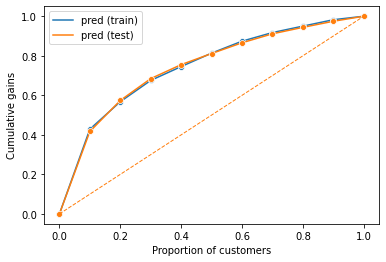

In [14]:
dct = {"train": pred_train, "test": pred_test}
fig = rsm.gains_plot(dct, "actual", 1, "pred").legend(title=None)

Model performs well in both training and testing dataset.

In [15]:
pred['pred_nn1'] = clf1.predict_proba(intuit75k_std[x_col])[:, 1]
pred['wave1_mailto_nn1'] = pred['pred_nn1']> 1.41/(60)
pred['wave2_mailto_nn1'] = pred['pred_nn1']> 1.41/(60*0.5)
act_wave1_prof_nn1 = functions.profit_actual(pred,mailto='wave1_mailto_nn1')[-1]
exp_wave2_prof_nn1 = functions.expected_profit_wave2(pred,mailto='wave2_mailto_nn1')[-1]

In [16]:
print(f"Actual profit in wave1:{act_wave1_prof_nn1}, Expected profit in wave2: {exp_wave2_prof_nn1}")

Actual profit in wave1:38106.96000000001, Expected profit in wave2: 447290.34


In [17]:
y_pred = pred.loc[pred.training==0,'wave1_mailto_nn1'].astype(int)
acc_nn1 = accuracy_score(y_test,y_pred)
pre_nn1 = precision_score(y_test,y_pred)
recall_nn1 = recall_score(y_test,y_pred)
auc_nn1 = roc_auc_score(y_test,y_pred)

In [18]:
print(f"Accuracy:{acc_nn1},\nPrecision: {pre_nn1},\nRecall:{recall_nn1},\nAUC:{auc_nn1}")

Accuracy:0.4507111111111111,
Precision: 0.07181984175289105,
Recall:0.8558476881233001,
AUC:0.6428371496652394


### 2.2 NN2

1 layer, 2 nodes

In [19]:
clf2 = nn(X_train, y_train, (2,))

In [20]:
pred_train = pd.DataFrame().assign(
    actual=y_train, pred=clf1.predict_proba(X_train)[:, 1] ## drop first column which is useless
)
pred_test = pd.DataFrame().assign(actual=y_test, pred=clf1.predict_proba(X_test)[:, 1])

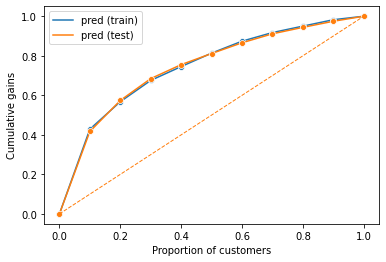

In [21]:
dct = {"train": pred_train, "test": pred_test}
fig = rsm.gains_plot(dct, "actual", 1, "pred").legend(title=None)

In [22]:
pred['pred_nn2'] = clf2.predict_proba(intuit75k_std[x_col])[:, 1]
pred['wave1_mailto_nn2'] = pred['pred_nn2']> 1.41/(60)
pred['wave2_mailto_nn2'] = pred['pred_nn2']> 1.41/(60*0.5)
act_wave1_prof_nn2 = functions.profit_actual(pred,mailto='wave1_mailto_nn2')[-1]
exp_wave2_prof_nn2 = functions.expected_profit_wave2(pred,mailto='wave2_mailto_nn2')[-1]

In [23]:
print(f"Actual profit in wave1:{act_wave1_prof_nn2}, Expected profit in wave2: {exp_wave2_prof_nn2}")

Actual profit in wave1:38115.9, Expected profit in wave2: 450670.95


In [24]:
y_pred = pred.loc[pred.training==0,'wave1_mailto_nn2'].astype(int)
acc_nn2 = accuracy_score(y_test,y_pred)
pre_nn2 = precision_score(y_test,y_pred)
recall_nn2 = recall_score(y_test,y_pred)
auc_nn2 = roc_auc_score(y_test,y_pred)

In [25]:
print(f"Accuracy:{acc_nn2},\nPrecision: {pre_nn2},\nRecall:{recall_nn2},\nAUC:{auc_nn2}")

Accuracy:0.4564,
Precision: 0.07232897770945426,
Recall:0.8531278331822303,
AUC:0.6445383989951905


### 2.3 NN3

2 layered model

In [26]:
clf3 = nn(X_train, y_train, (3,))

In [27]:
pred['pred_nn3'] = clf3.predict_proba(intuit75k_std[x_col])[:, 1]
pred['wave1_mailto_nn3'] = pred['pred_nn3']> 1.41/(60)
pred['wave2_mailto_nn3'] = pred['pred_nn3']> 1.41/(60*0.5)
act_wave1_prof_nn3 = functions.profit_actual(pred,mailto='wave1_mailto_nn3')[-1]
exp_wave2_prof_nn3 = functions.expected_profit_wave2(pred,mailto='wave2_mailto_nn3')[-1]

In [28]:
print(f"Actual profit in wave1:{act_wave1_prof_nn3}, Expected profit in wave2: {exp_wave2_prof_nn3}")

Actual profit in wave1:38099.16, Expected profit in wave2: 435620.58


We see that NN3 has the worst performance compared to previous models

### 2.4 Tuning the neural network model

Check the tuning process in sub-notebook/nn-cv.ipython.
We tried hls = [(1,),(2,),(3,),(1,1),(2,1),(3,1)], and among them (3,1) perform the best

In [29]:
# change max_iter
def nn_big(X, y, hlsizes=(1,), max_iter=10000):
    return MLPClassifier(
        activation="tanh",
        solver="lbfgs",
        hidden_layer_sizes=hlsizes,
        random_state=1234,
        max_iter=max_iter,
    ).fit(X, y)

In [30]:
clf3_1 = nn_big(X_train, y_train, (3,1)) # this takes time to run

In [31]:
pred_train = pd.DataFrame().assign(
    actual=y_train, pred=clf1.predict_proba(X_train)[:, 1] ## drop first column which is useless
)
pred_test = pd.DataFrame().assign(actual=y_test, pred=clf1.predict_proba(X_test)[:, 1])

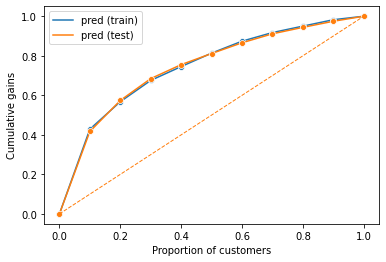

In [32]:
dct = {"train": pred_train, "test": pred_test}
fig = rsm.gains_plot(dct, "actual", 1, "pred").legend(title=None)

In [33]:
pred['pred_nn3_1'] = clf3_1.predict_proba(intuit75k_std[x_col])[:, 1]
pred['wave1_mailto_nn3_1'] = pred['pred_nn3_1']> 1.41/(60)
pred['wave2_mailto_nn3_1'] = pred['pred_nn3_1']> 1.41/(60*0.5)
act_wave1_prof_nn3_1 = functions.profit_actual(pred,mailto='wave1_mailto_nn3_1')[-1]
exp_wave2_prof_nn3_1 = functions.expected_profit_wave2(pred,mailto='wave2_mailto_nn3_1')[-1]

In [34]:
print(f"Actual profit in wave1:{act_wave1_prof_nn3_1}, Expected profit in wave2: {exp_wave2_prof_nn3_1}")

Actual profit in wave1:38477.82, Expected profit in wave2: 447308.64


In [35]:
y_pred = pred.loc[pred.training==0,'wave1_mailto_nn3_1'].astype(int)
acc_nn3_1 = accuracy_score(y_test,y_pred)
pre_nn3_1 = precision_score(y_test,y_pred)
recall_nn3_1 = recall_score(y_test,y_pred)
auc_nn3_1 = roc_auc_score(y_test,y_pred)

In [36]:
print(f"Accuracy:{acc_nn3_1},\nPrecision: {pre_nn3_1},\nRecall:{recall_nn3_1},\nAUC:{auc_nn3_1}")

Accuracy:0.4786222222222222,
Precision: 0.07481196991518643,
Recall:0.8476881233000907,
AUC:0.653642631543021


### 2.5 Special Topic: different activation and solver

Given that nn3-1,nn2,nn1 perform best in the previous analysis, this section will try relu activation and adam solver.

Check sub-notebooks/relu.ipynb for details. Among them, relu on nn1 perform the best

In [37]:
def nn_relu(X, y, hlsizes=(1,), max_iter=10000):
    return MLPClassifier(
        activation="relu",
        solver="adam",
        hidden_layer_sizes=hlsizes,
        random_state=1234,
        max_iter=max_iter,
    ).fit(X, y)

In [38]:
clf1_relu = nn_relu(X_train, y_train, (1,))

In [39]:
pred_train = pd.DataFrame().assign(
    actual=y_train, pred=clf1.predict_proba(X_train)[:, 1] ## drop first column which is useless
)
pred_test = pd.DataFrame().assign(actual=y_test, pred=clf1.predict_proba(X_test)[:, 1])

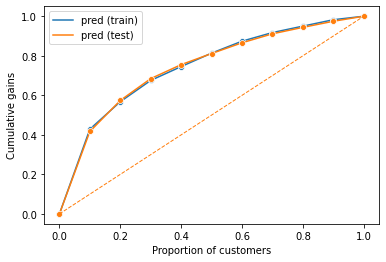

In [40]:
dct = {"train": pred_train, "test": pred_test}
fig = rsm.gains_plot(dct, "actual", 1, "pred").legend(title=None)

In [41]:
pred['pred_nn1_relu'] = clf1_relu.predict_proba(intuit75k_std[x_col])[:, 1]
pred['wave1_mailto_nn1_relu'] = pred['pred_nn1_relu']> 1.41/(60)
pred['wave2_mailto_nn1_relu'] = pred['pred_nn1_relu']> 1.41/(60*0.5)
act_wave1_prof_nn1_relu = functions.profit_actual(pred,mailto='wave1_mailto_nn1_relu')[-1]
exp_wave2_prof_nn1_relu = functions.expected_profit_wave2(pred,mailto='wave2_mailto_nn1_relu')[-1]

In [42]:
print(f"Actual profit in wave1:{act_wave1_prof_nn1_relu}, Expected profit in wave2: {exp_wave2_prof_nn1_relu}")

Actual profit in wave1:38414.25, Expected profit in wave2: 441492.09


In [43]:
y_pred = pred.loc[pred.training==0,'wave1_mailto_nn1_relu'].astype(int)
acc_nn1_relu = accuracy_score(y_test,y_pred)
pre_nn1_relu = precision_score(y_test,y_pred)
recall_nn1_relu = recall_score(y_test,y_pred)
auc_nn1_relu = roc_auc_score(y_test,y_pred)

In [44]:
print(f"Accuracy:{acc_nn1_relu},\nPrecision: {pre_nn1_relu},\nRecall:{recall_nn1_relu},\nAUC:{auc_nn1_relu}")

Accuracy:0.41173333333333334,
Precision: 0.06898756660746004,
Recall:0.8803263825929284,
AUC:0.6339520402005161


## 3.Decision Tree

In [46]:
from sklearn.tree import DecisionTreeClassifier

In [47]:
def dt_classify(X,y, md=1):
    dt = DecisionTreeClassifier(max_depth = md, random_state=1234).fit(X,y)
    return dt

## 3.1 max-depth 1 Overview

In [48]:
dt1= dt_classify(X_train,y_train)

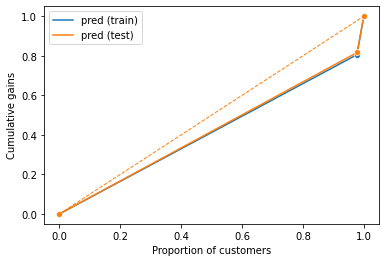

In [49]:
pred_train = pd.DataFrame().assign(
    actual=y_train, pred=dt1.predict_proba(X_train)[:, 1] ## drop first column which is useless
)
pred_test = pd.DataFrame().assign(actual=y_test, pred=dt1.predict_proba(X_test)[:, 1])

dct = {"train": pred_train, "test": pred_test}
fig = rsm.gains_plot(dct, "actual", 1, "pred").legend(title=None)

The graph indicates that max_depth = 1 can't be a good model, then the next step is tuning

## 3.2 Decision Tree Tuning

Check sub-notebooks/dt-cv.ipynb for details. Among them, when max depth =6 we get the best performance.

In [50]:
dt6 = dt_classify(X_train, y_train, 6)
pred['pred_dt6'] = dt6.predict_proba(intuit75k_std[x_col])[:, 1]
pred['wave1_mailto_dt6'] = pred['pred_dt6']> 1.41/(60)
pred['wave2_mailto_dt6'] = pred['pred_dt6']> 1.41/(60*0.5)
act_wave1_prof_dt6 = functions.profit_actual(pred,mailto='wave1_mailto_dt6')[-1]
exp_wave2_prof_dt6 = functions.expected_profit_wave2(pred,mailto='wave2_mailto_dt6')[-1]
print(f"Actual profit in wave1:{act_wave1_prof_dt6}, Expected profit in wave2: {exp_wave2_prof_dt6}")

Actual profit in wave1:36822.3, Expected profit in wave2: 437476.08


### 3.3 Special topic: Use entropy as criterion

In [51]:
def dt_classify_rnt(X,y, md=1):
    dt = DecisionTreeClassifier(max_depth = md, random_state=1234,criterion ='entropy').fit(X,y)
    return dt

In [52]:
dt6_ent = dt_classify_rnt(X_train, y_train, 6)
pred['pred_dt6_ent'] = dt6_ent.predict_proba(intuit75k_std[x_col])[:, 1]
pred['wave1_mailto_dt6_ent'] = pred['pred_dt6_ent']> 1.41/(60)
pred['wave2_mailto_dt6_ent'] = pred['pred_dt6_ent']> 1.41/(60*0.5)
act_wave1_prof_dt6_ent = functions.profit_actual(pred,mailto='wave1_mailto_dt6_ent')[-1]
exp_wave2_prof_dt6_ent = functions.expected_profit_wave2(pred,mailto='wave2_mailto_dt6_ent')[-1]
print(f"Actual profit in wave1:{act_wave1_prof_dt6_ent}, Expected profit in wave2: {exp_wave2_prof_dt6_ent}")

Actual profit in wave1:36278.94, Expected profit in wave2: 403217.82


If we keep max depth = 6, entropy perform worse than gini

### 3.4 Bagging of decision tree

In [53]:
from sklearn.ensemble import BaggingClassifier

dt6 = dt_classify(X_train, y_train, 6)
bc = BaggingClassifier(base_estimator=dt6, n_estimators=300, random_state=1234).fit(X_train, y_train)

In [54]:
pred['pred_bc'] = bc.predict_proba(intuit75k_std[x_col])[:, 1]
pred['wave1_mailto_bc'] = pred['pred_bc']> 1.41/(60)
pred['wave2_mailto_bc'] = pred['pred_bc']> 1.41/(60*0.5)
act_wave1_prof_bc = functions.profit_actual(pred,mailto='wave1_mailto_bc')[-1]
exp_wave2_prof_bc = functions.expected_profit_wave2(pred,mailto='wave2_mailto_bc')[-1]
print(f"Actual profit in wave1:{act_wave1_prof_bc}, Expected profit in wave2: {exp_wave2_prof_bc}")

Actual profit in wave1:37207.8, Expected profit in wave2: 439399.38


Bagging is better than dt6

## 4. Random Forest

In [55]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=300, random_state=1234).fit(X_train, y_train)

In [56]:
pred['pred_rf'] = rf.predict_proba(intuit75k_std[x_col])[:, 1]
pred['wave1_mailto_rf'] = pred['pred_rf']> 1.41/(60)
pred['wave2_mailto_rf'] = pred['pred_rf']> 1.41/(60*0.5)
act_wave1_prof_rf = functions.profit_actual(pred,mailto='wave1_mailto_rf')[-1]
exp_wave2_prof_rf = functions.expected_profit_wave2(pred,mailto='wave2_mailto_rf')[-1]
print(f"Actual profit in wave1:{act_wave1_prof_rf}, Expected profit in wave2: {exp_wave2_prof_rf}")

Actual profit in wave1:34283.94, Expected profit in wave2: 363922.98000000004


Random forest performs not as good as other models.

## 5. Gradient Boosting

In [57]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=1234).fit(X_train, y_train)

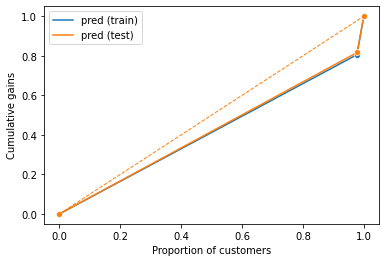

In [58]:
pred_train = pd.DataFrame().assign(
    actual=y_train, pred=gb.predict_proba(X_train)[:, 1] ## drop first column which is useless
)
pred_test = pd.DataFrame().assign(actual=y_test, pred=gb.predict_proba(X_test)[:, 1])

dct = {"train": pred_train, "test": pred_test}
fig = rsm.gains_plot(dct, "actual", 1, "pred").legend(title=None)

The graph indicates that learning rate = 1 and  max depth =1 can't be a good model, then the next step is tuning

### 5.1 Gradient Boosting Tuning

Check sub-notebooks/gb-cv.ipynb for details. Among them, when learning_rate = 0.1 and max depth =3 we get the best performance.

In [59]:
gb_cv = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=1234).fit(X_train, y_train)

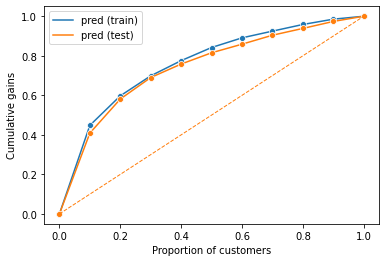

In [60]:
pred_train = pd.DataFrame().assign(
    actual=y_train, pred=gb_cv.predict_proba(X_train)[:, 1] ## drop first column which is useless
)
pred_test = pd.DataFrame().assign(actual=y_test, pred=gb_cv.predict_proba(X_test)[:, 1])

dct = {"train": pred_train, "test": pred_test}
fig = rsm.gains_plot(dct, "actual", 1, "pred").legend(title=None)

In [61]:
pred['pred_gb'] = gb_cv.predict_proba(intuit75k_std[x_col])[:, 1]
pred['wave1_mailto_gb'] = pred['pred_gb']> 1.41/(60)
pred['wave2_mailto_gb'] = pred['pred_gb']> 1.41/(60*0.5)
act_wave1_prof_gb = functions.profit_actual(pred,mailto='wave1_mailto_gb')[-1]
exp_wave2_prof_gb = functions.expected_profit_wave2(pred,mailto='wave2_mailto_gb')[-1]
print(f"Actual profit in wave1:{act_wave1_prof_gb}, Expected profit in wave2: {exp_wave2_prof_gb}")

Actual profit in wave1:38363.76, Expected profit in wave2: 452725.62


In [62]:
y_pred = pred.loc[pred.training==0,'wave1_mailto_gb'].astype(int)
acc_gb = accuracy_score(y_test,y_pred)
pre_gb = precision_score(y_test,y_pred)
recall_gb = recall_score(y_test,y_pred)
auc_gb = roc_auc_score(y_test,y_pred)

In [63]:
print(f"Accuracy:{acc_gb},\nPrecision: {pre_gb},\nRecall:{recall_gb},\nAUC:{auc_gb}")

Accuracy:0.47142222222222224,
Precision: 0.07398926089703095,
Recall:0.8495013599274706,
AUC:0.6507169369156444


## 6.Compare

- Logit ( Base, will not be used to prediction)
- NN: nn3-1, nn2 ,nn1,nn1_relu
- Decision tree: dt6
- Bagging: bc ( based on dt6)
- Random Forest
- Gradient Boosting

In [64]:
plot_data  = pd.DataFrame(
{ 'Name':['Logit','nn1','nn2','nn3-1','nn1_relu','dTree','Bagging','rf','gb'],
'Wave1': [act_wave1_prof_lr1,act_wave1_prof_nn1,act_wave1_prof_nn2,act_wave1_prof_nn3_1,act_wave1_prof_nn1_relu,act_wave1_prof_dt6,act_wave1_prof_bc,act_wave1_prof_rf,act_wave1_prof_gb],
'Wave2': [exp_wave2_prof_lr1, exp_wave2_prof_nn1,exp_wave2_prof_nn2,exp_wave2_prof_nn3_1,exp_wave2_prof_nn1_relu,exp_wave2_prof_dt6,exp_wave2_prof_bc,exp_wave2_prof_rf,exp_wave2_prof_gb]
})

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'rf'),
  Text(1, 0, 'dTree'),
  Text(2, 0, 'Bagging'),
  Text(3, 0, 'nn1'),
  Text(4, 0, 'nn2'),
  Text(5, 0, 'Logit'),
  Text(6, 0, 'gb'),
  Text(7, 0, 'nn1_relu'),
  Text(8, 0, 'nn3-1')])

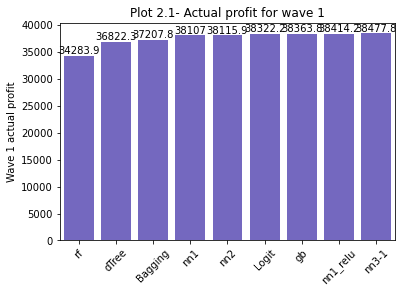

In [65]:
fig = sns.barplot(data = plot_data,x='Name',y='Wave1',color ="slateblue",order=plot_data.sort_values('Wave1').Name)
fig.set(xlabel="", ylabel="Wave 1 actual profit", title="Plot 2.1- Actual profit for wave 1")
fig.bar_label(fig.containers[0])
plt.xticks(rotation=45)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'rf'),
  Text(1, 0, 'dTree'),
  Text(2, 0, 'Bagging'),
  Text(3, 0, 'nn1'),
  Text(4, 0, 'nn2'),
  Text(5, 0, 'Logit'),
  Text(6, 0, 'gb'),
  Text(7, 0, 'nn1_relu'),
  Text(8, 0, 'nn3-1')])

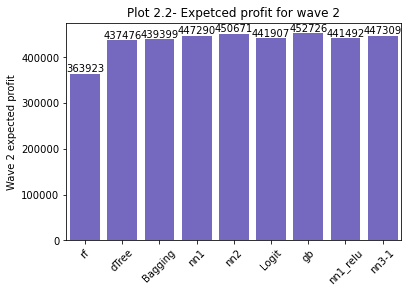

In [66]:
fig = sns.barplot(data = plot_data,x='Name',y='Wave2',color ="slateblue",order=plot_data.sort_values('Wave1').Name)
fig.set(xlabel="", ylabel="Wave 2 expected profit", title="Plot 2.2- Expetced profit for wave 2")
fig.bar_label(fig.containers[0])
plt.xticks(rotation=45)

Given the performance for both actual profit and expected profit, we could compare the prediction results from nn1,nn2,nn3-1 and gb

### 6.2 Average probability

In [67]:
pred['pred_best4'] = (pred['pred_nn1'] + pred['pred_nn2']+pred['pred_nn3_1']+pred['pred_gb'])/4

In [68]:
pred['wave1_mailto_b4'] = pred['pred_best4']> 1.41/(60)
pred['wave2_mailto_b4'] = pred['pred_best4']> 1.41/(60*0.5)
act_wave1_prof_b4 = functions.profit_actual(pred,mailto='wave1_mailto_b4')[-1]
exp_wave2_prof_b4 = functions.expected_profit_wave2(pred,mailto='wave2_mailto_b4')[-1]
print(f"Actual profit in wave1:{act_wave1_prof_b4}, Expected profit in wave2: {exp_wave2_prof_b4}")

Actual profit in wave1:38147.22, Expected profit in wave2: 459422.01


In [69]:
y_pred = pred.loc[pred.training==0,'wave1_mailto_b4'].astype(int)
acc_b4 = accuracy_score(y_test,y_pred)
pre_b4 = precision_score(y_test,y_pred)
recall_b4 = recall_score(y_test,y_pred)
auc_b4 = roc_auc_score(y_test,y_pred)

In [70]:
print(f"Accuracy:{acc_b4},\nPrecision: {pre_b4},\nRecall:{recall_b4},\nAUC:{auc_b4}")

Accuracy:0.4501777777777778,
Precision: 0.07181942544459645,
Recall:0.85675430643699,
AUC:0.6429866779182193
